# 1.24c4: Momentum-State Correlation - Do Forces Drive Phase Transitions?

**Purpose:** Test if Adam momentum directly drives the classical → quantum → frozen transitions.

## The Question

From 1.24c, we know dead tokens undergo state transitions:
- **Classical** (t=0-150): Smooth motion, displacement >> 10×ULP
- **Quantum** (t=150-550): Lattice hopping, ~70% dimensions quantized
- **Early frost** (t~300): ~30% tokens freeze
- **Thaw** (t=300-450): Frozen drops back to ~5%
- **Fimbulwinter** (t>550): Final freeze, >90% frozen

From 1.24c2, we know momentum and gradients show spike-dip-level pattern:
- **Spike** (t=0-50): Peak forces
- **Dip** (t=200-250): Sharp drop
- **Level/Recovery** (t=250-450): Slight rise
- **Final decay** (t>450): Flatten to zero

**Hypothesis:** Momentum IS the thermal energy keeping tokens unfrozen.
- High momentum → classical motion
- Momentum drops → quantum transition
- Momentum minimum → peak freeze (early frost)
- Momentum recovery → thaw
- Momentum → 0 → final freeze

## What We'll Do

1. **Load state fractions** from 1.24c (classical, quantum, frozen)
2. **Load momentum norms** from 1.24c2
3. **Plot overlays** to see if curves track together
4. **Compute correlations** (Pearson r) between momentum and each state
5. **Verdict:** Does momentum explain the phase transitions?

## Parameters

In [1]:
# Data paths
DATA_PATH = "../tensors/Flannel/1.20h_flannel_7.safetensors"
MASK_PATH = "../tensors/Flannel/live_dead_tokens.safetensors"

# Key windows (from 1.24c2)
SPIKE_WINDOW = (0, 50)
DIP_WINDOW = (200, 250)
RECOVERY_WINDOW = (250, 450)
FREEZE_WINDOW = (450, 600)

# ULP detection parameters (from 1.24c)
QUANTIZED_THRESHOLD = 0.1  # Consider displacement quantized if within 0.1 of integer ULP
QUANTUM_FRACTION = 0.7     # >70% dimensions quantized = quantum state
CLASSICAL_MULTIPLE = 10.0  # Displacement > 10× mean ULP = classical

# Plot settings
DPI = 200
FIGSIZE = (12, 6)

print("✓ Parameters set")

✓ Parameters set


## Imports

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from safetensors.torch import load_file
from pathlib import Path

print("✓ Imports complete")

✓ Imports complete


## Device Detection

In [3]:
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

print(f"Using device: {device}")

Using device: mps


## Load Data

In [4]:
print("Loading Flannel 7 data...\n")

data = load_file(DATA_PATH)

# Extract tensors
W = data['W'][0].float()  # (1001, 10000, 64)
momentum_W = data['momentum_W'][0].float()  # (1001, 10000, 64)

# Load token masks
mask_data = load_file(MASK_PATH)
dead_mask = mask_data['dead_mask'].bool()
live_mask = mask_data['live_mask'].bool()

print(f"W: {tuple(W.shape)}")
print(f"Momentum: {tuple(momentum_W.shape)}")
print(f"Dead tokens: {dead_mask.sum().item()}")
print(f"\n✓ Data loaded")

Loading Flannel 7 data...

W: (1001, 10000, 64)
Momentum: (1001, 10000, 64)
Dead tokens: 3699

✓ Data loaded


## Compute Momentum Norms

In [5]:
print("Computing momentum norms...\n")

# Extract dead token momentum
momentum_dead = momentum_W[:, dead_mask, :]  # (1001, 3699, 64)

# Compute per-token momentum norms, then mean across tokens
momentum_norms = torch.norm(momentum_dead, dim=2).mean(dim=1)  # (1001,)

print(f"Momentum norms shape: {tuple(momentum_norms.shape)}")
print(f"Range: {momentum_norms.min():.6e} to {momentum_norms.max():.6e}")
print(f"\n✓ Momentum computed")

Computing momentum norms...

Momentum norms shape: (1001,)
Range: 0.000000e+00 to 4.808435e-04

✓ Momentum computed


## Compute State Fractions (Classical, Quantum, Frozen)

Replicate the ULP-based classification from 1.24c.

In [6]:
print("Computing state fractions...\n")

# Extract dead tokens only
W_dead = W[:, dead_mask, :]  # (1001, 3699, 64)
n_dead = W_dead.shape[1]
n_steps = W_dead.shape[0]

# Compute displacements
delta_W = W_dead[1:] - W_dead[:-1]  # (1000, 3699, 64)

# Compute per-element ULPs using frexp
_, exponents = torch.frexp(W_dead[:-1].abs())  # (1000, 3699, 64)
ulps = 2.0 ** (exponents - 7)  # bfloat16 has 7 mantissa bits

# Normalize displacements by ULP
normalized_delta = delta_W / (ulps + 1e-10)

# Check if displacement is integer multiple of ULP
rounded = torch.round(normalized_delta)
is_quantized = torch.abs(normalized_delta - rounded) < QUANTIZED_THRESHOLD  # (1000, 3699, 64)

# Per-token metrics
quantized_fraction = is_quantized.float().mean(dim=2)  # (1000, 3699) - fraction of dims quantized
displacement_norm = torch.norm(delta_W, dim=2)  # (1000, 3699)
mean_ulp = ulps.mean(dim=2)  # (1000, 3699)

# Classify each token at each step
is_frozen = (displacement_norm == 0)
is_quantum = (~is_frozen) & (quantized_fraction > QUANTUM_FRACTION) & (displacement_norm < CLASSICAL_MULTIPLE * mean_ulp)
is_classical = (~is_frozen) & (~is_quantum)

# Compute fractions across all dead tokens
frozen_frac = is_frozen.float().mean(dim=1)  # (1000,)
quantum_frac = is_quantum.float().mean(dim=1)  # (1000,)
classical_frac = is_classical.float().mean(dim=1)  # (1000,)

print(f"State fractions shape: {tuple(classical_frac.shape)}")
print(f"Classical range: {classical_frac.min():.3f} to {classical_frac.max():.3f}")
print(f"Quantum range: {quantum_frac.min():.3f} to {quantum_frac.max():.3f}")
print(f"Frozen range: {frozen_frac.min():.3f} to {frozen_frac.max():.3f}")
print(f"\n✓ State fractions computed")

Computing state fractions...

State fractions shape: (1000,)
Classical range: 0.000 to 1.000
Quantum range: 0.000 to 1.000
Frozen range: 0.000 to 1.000

✓ State fractions computed


## Visualization 1: Momentum vs State Fractions Overlay

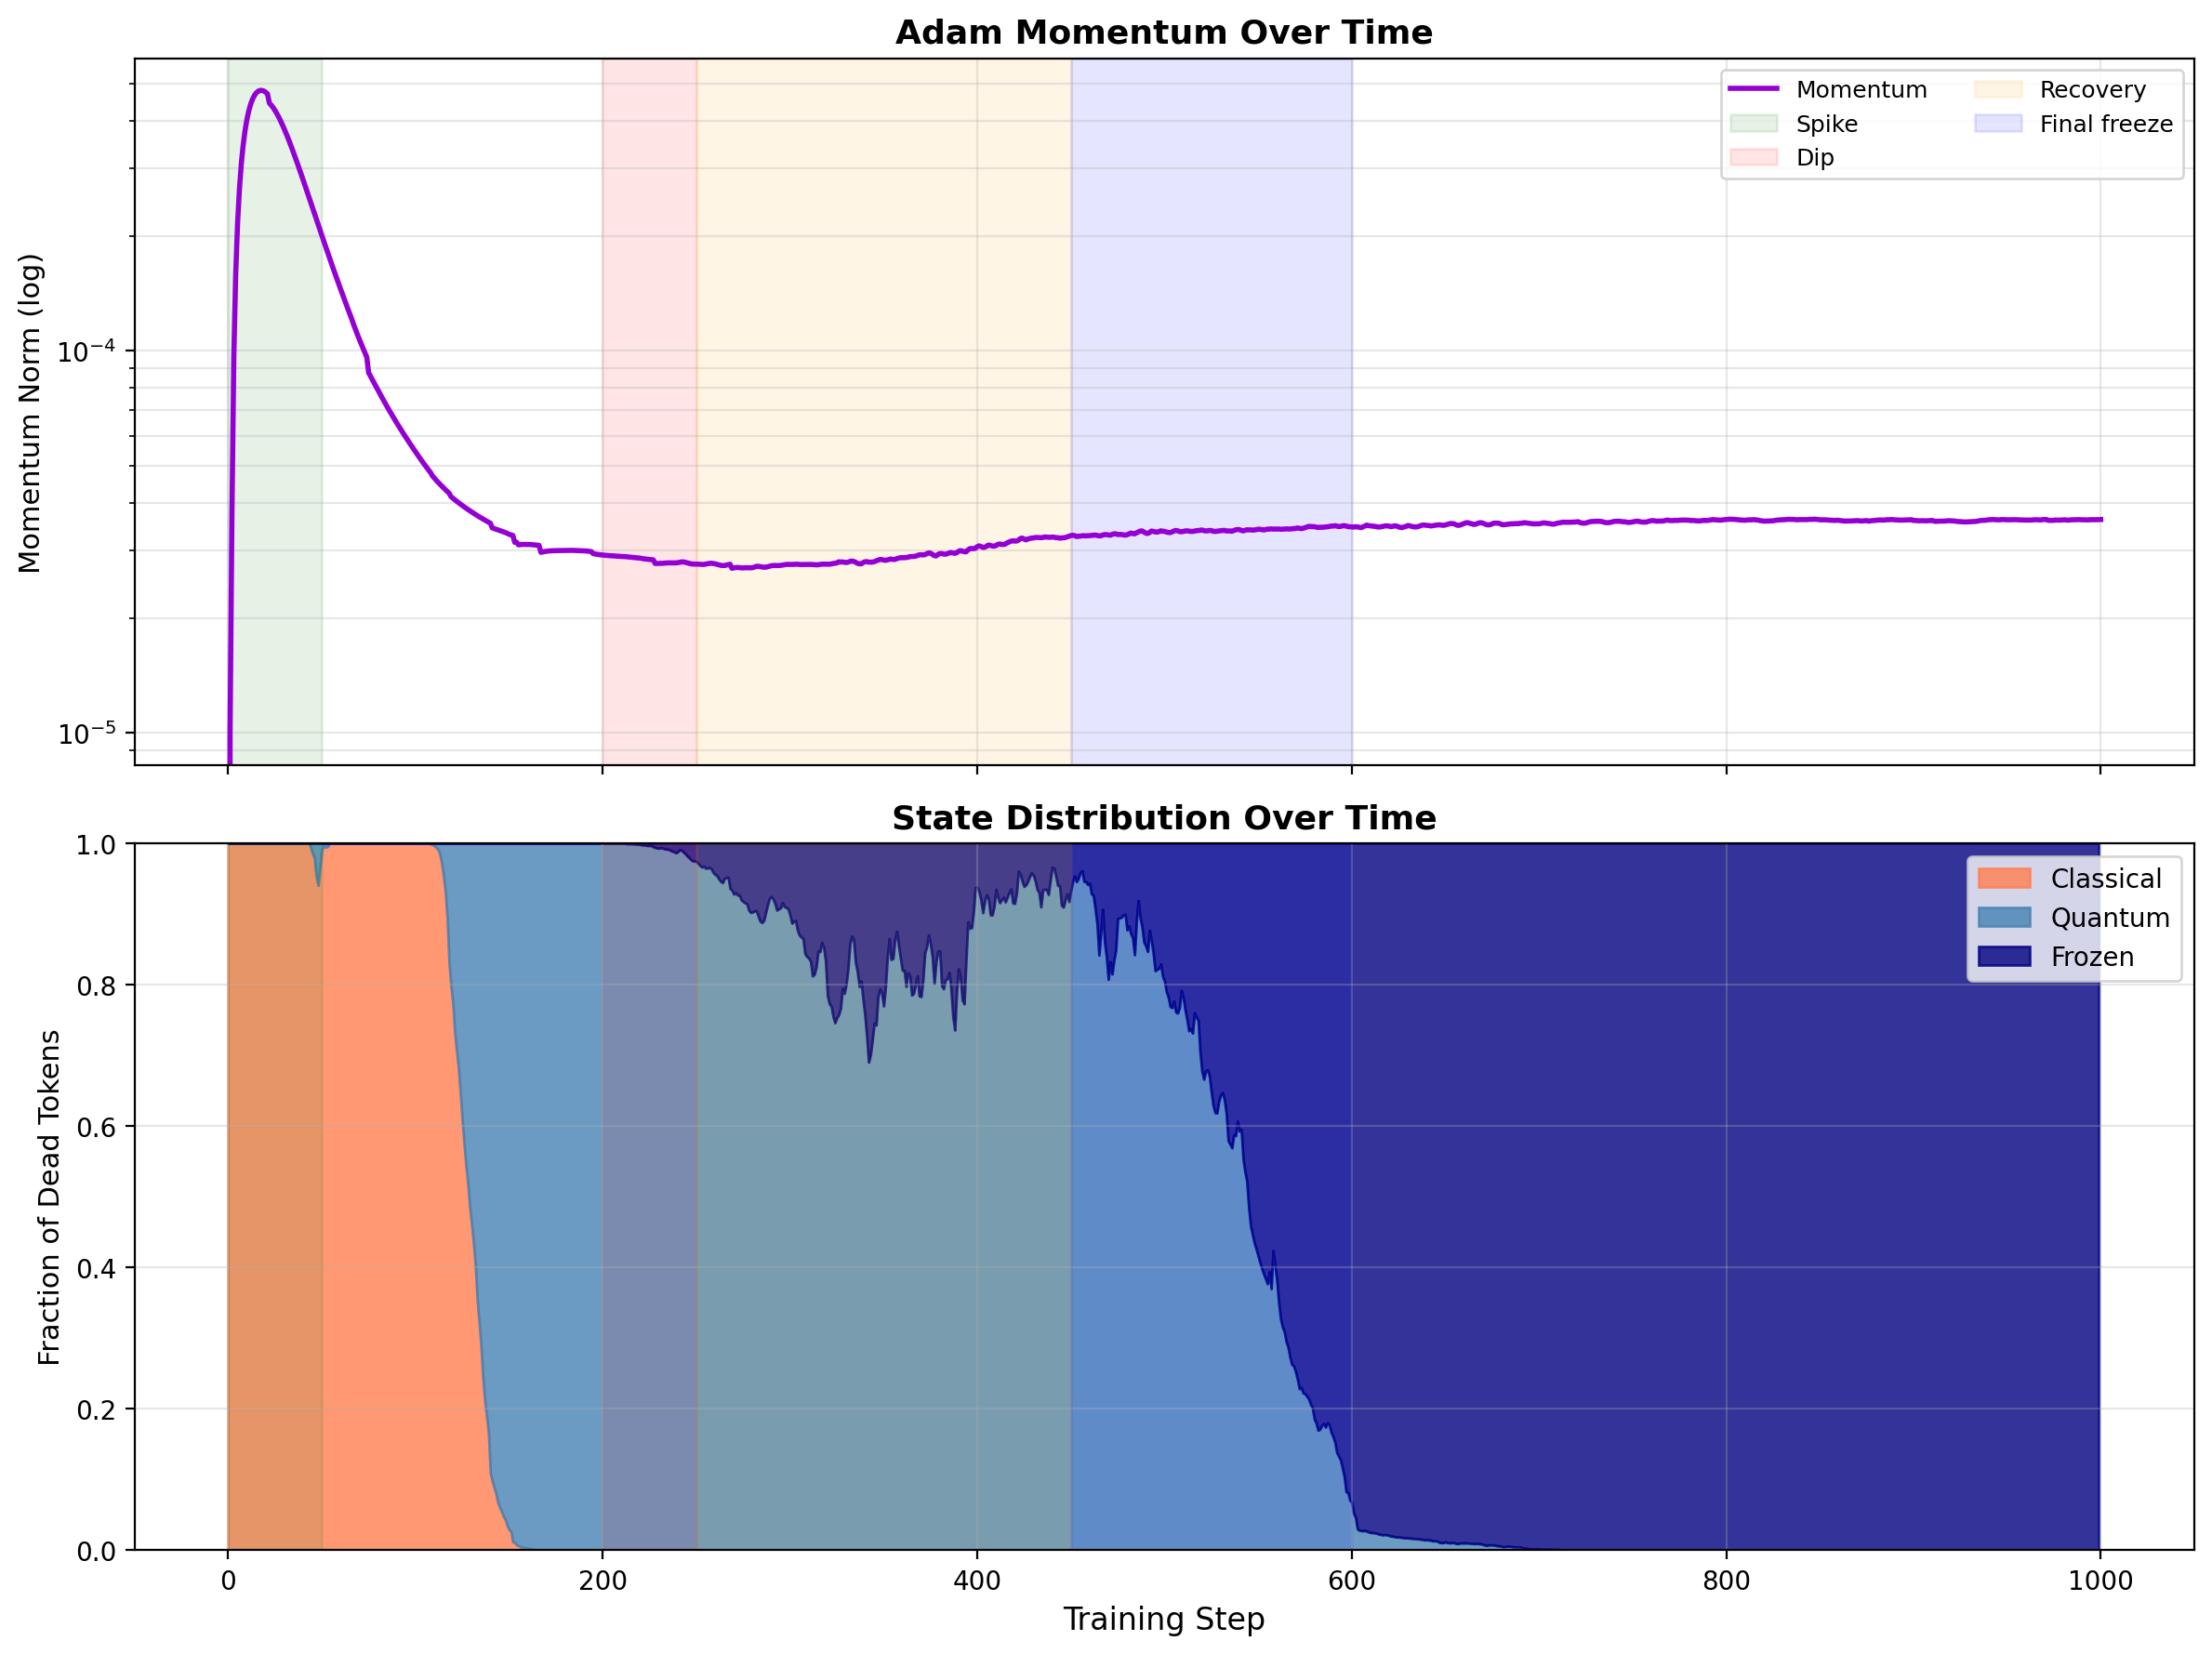


Interpretation: Do the curves move together?
  If momentum drops → classical shrinks and quantum/frozen grow
  If momentum recovers → frozen shrinks and quantum/classical grow
  Then momentum IS the thermal energy driving phase transitions


In [7]:
# Two-panel plot: momentum + state fractions stacked area
fig, axes = plt.subplots(2, 1, figsize=(FIGSIZE[0], FIGSIZE[1]*1.5), dpi=DPI, sharex=True)

# Panel 1: Momentum norm over time
ax1 = axes[0]
ax1.semilogy(momentum_norms.numpy(), linewidth=2, color='darkviolet', label='Momentum')
ax1.axvspan(*SPIKE_WINDOW, alpha=0.1, color='green', label='Spike')
ax1.axvspan(*DIP_WINDOW, alpha=0.1, color='red', label='Dip')
ax1.axvspan(*RECOVERY_WINDOW, alpha=0.1, color='orange', label='Recovery')
ax1.axvspan(*FREEZE_WINDOW, alpha=0.1, color='blue', label='Final freeze')
ax1.set_ylabel('Momentum Norm (log)', fontsize=11)
ax1.set_title('Adam Momentum Over Time', fontweight='bold', fontsize=13)
ax1.legend(loc='upper right', fontsize=9, ncol=2)
ax1.grid(True, alpha=0.3, which='both')

# Panel 2: State fractions (stacked area)
ax2 = axes[1]
t = np.arange(len(classical_frac))
ax2.fill_between(t, 0, classical_frac.numpy(), label='Classical', color='coral', alpha=0.8)
ax2.fill_between(t, classical_frac.numpy(), 
                 (classical_frac + quantum_frac).numpy(), 
                 label='Quantum', color='steelblue', alpha=0.8)
ax2.fill_between(t, (classical_frac + quantum_frac).numpy(), 1.0,
                 label='Frozen', color='navy', alpha=0.8)
ax2.axvspan(*SPIKE_WINDOW, alpha=0.1, color='green')
ax2.axvspan(*DIP_WINDOW, alpha=0.1, color='red')
ax2.axvspan(*RECOVERY_WINDOW, alpha=0.1, color='orange')
ax2.axvspan(*FREEZE_WINDOW, alpha=0.1, color='blue')
ax2.set_xlabel('Training Step', fontsize=12)
ax2.set_ylabel('Fraction of Dead Tokens', fontsize=11)
ax2.set_title('State Distribution Over Time', fontweight='bold', fontsize=13)
ax2.legend(loc='upper right', fontsize=10)
ax2.set_ylim([0, 1])
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nInterpretation: Do the curves move together?")
print("  If momentum drops → classical shrinks and quantum/frozen grow")
print("  If momentum recovers → frozen shrinks and quantum/classical grow")
print("  Then momentum IS the thermal energy driving phase transitions")

## Visualization 2: Direct Comparison - Momentum vs Frozen Fraction

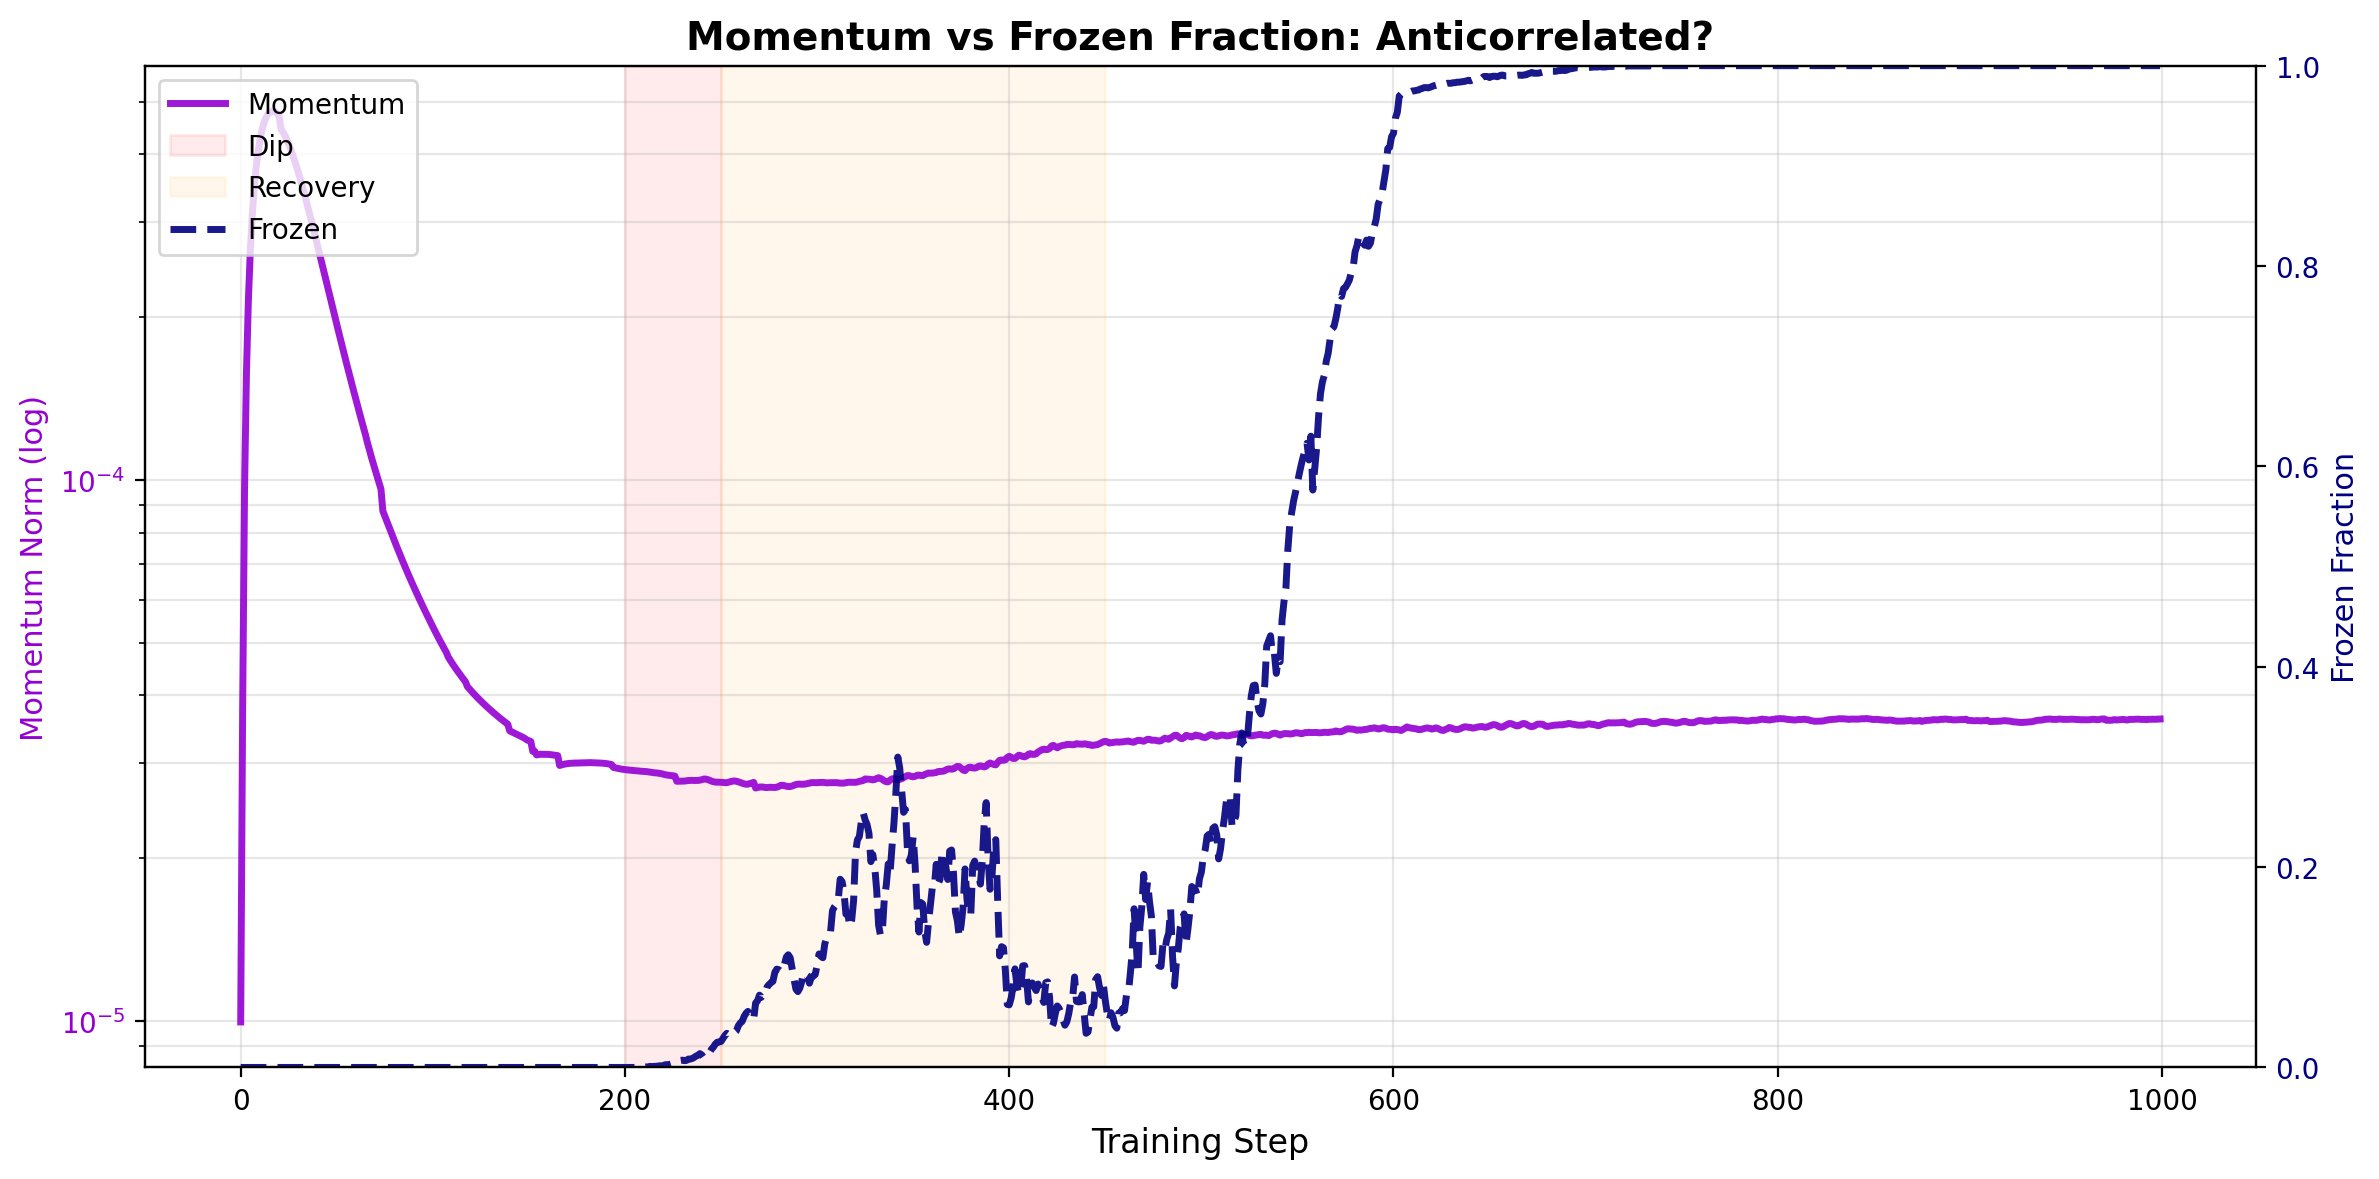


Hypothesis: If frozen fraction peaks when momentum bottoms out,
            momentum is the thermal energy preventing freeze.


In [8]:
# Dual-axis plot: momentum and frozen fraction on same plot
fig, ax1 = plt.subplots(figsize=FIGSIZE, dpi=DPI)

# Left axis: Momentum (log scale)
color = 'darkviolet'
ax1.set_xlabel('Training Step', fontsize=12)
ax1.set_ylabel('Momentum Norm (log)', color=color, fontsize=11)
ax1.semilogy(momentum_norms[1:].numpy(), linewidth=2.5, color=color, alpha=0.9, label='Momentum')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, alpha=0.3, which='both')

# Right axis: Frozen fraction (linear scale)
ax2 = ax1.twinx()
color = 'navy'
ax2.set_ylabel('Frozen Fraction', color=color, fontsize=11)
ax2.plot(frozen_frac.numpy(), linewidth=2.5, color=color, alpha=0.9, label='Frozen', linestyle='--')
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim([0, 1])

# Shade key windows
ax1.axvspan(*DIP_WINDOW, alpha=0.08, color='red', zorder=-1, label='Dip')
ax1.axvspan(*RECOVERY_WINDOW, alpha=0.08, color='orange', zorder=-1, label='Recovery')

ax1.set_title('Momentum vs Frozen Fraction: Anticorrelated?', fontsize=14, fontweight='bold')

# Combined legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=10)

plt.tight_layout()
plt.show()

print("\nHypothesis: If frozen fraction peaks when momentum bottoms out,")
print("            momentum is the thermal energy preventing freeze.")

## Correlation Analysis

In [9]:
print("="*80)
print("CORRELATION ANALYSIS: MOMENTUM vs STATE FRACTIONS")
print("="*80 + "\n")

# Align arrays (state fractions are 1000, momentum is 1001)
momentum_aligned = momentum_norms[1:]  # Drop t=0

# Compute Pearson correlations
def pearson(x, y):
    """Compute Pearson correlation between two 1D tensors"""
    return torch.corrcoef(torch.stack([x, y]))[0, 1].item()

corr_classical = pearson(momentum_aligned, classical_frac)
corr_quantum = pearson(momentum_aligned, quantum_frac)
corr_frozen = pearson(momentum_aligned, frozen_frac)

print(f"Pearson Correlation: Momentum vs State Fraction")
print(f"  Classical:  {corr_classical:+.3f}")
print(f"  Quantum:    {corr_quantum:+.3f}")
print(f"  Frozen:     {corr_frozen:+.3f}")
print()

# Interpretation
if corr_frozen < -0.5:
    print("✓ STRONG ANTICORRELATION: Momentum ↑ → Frozen ↓")
    print("  High momentum prevents freezing (thermal energy hypothesis)")
elif corr_frozen < -0.3:
    print("✓ MODERATE ANTICORRELATION: Momentum ↑ → Frozen ↓")
    print("  Some evidence for thermal energy hypothesis")
else:
    print("✗ WEAK/NO ANTICORRELATION")
    print("  Momentum does not clearly prevent freezing")

print()

if corr_classical > 0.5:
    print("✓ STRONG CORRELATION: Momentum ↑ → Classical ↑")
    print("  High momentum drives smooth classical motion")
elif corr_classical > 0.3:
    print("✓ MODERATE CORRELATION: Momentum ↑ → Classical ↑")
    print("  Some evidence momentum drives classical motion")
else:
    print("✗ WEAK/NO CORRELATION")
    print("  Momentum does not clearly drive classical motion")

print("\n" + "="*80 + "\n")

CORRELATION ANALYSIS: MOMENTUM vs STATE FRACTIONS

Pearson Correlation: Momentum vs State Fraction
  Classical:  +0.695
  Quantum:    -0.266
  Frozen:     -0.251

✗ WEAK/NO ANTICORRELATION
  Momentum does not clearly prevent freezing

✓ STRONG CORRELATION: Momentum ↑ → Classical ↑
  High momentum drives smooth classical motion




## Window-Specific Correlations

In [10]:
print("="*80)
print("WINDOW-SPECIFIC CORRELATIONS")
print("="*80 + "\n")

def window_corr(window, x, y):
    """Compute correlation within a specific time window"""
    s, e = window
    return pearson(x[s:e], y[s:e])

windows = [
    ("Spike", SPIKE_WINDOW),
    ("Dip", DIP_WINDOW),
    ("Recovery", RECOVERY_WINDOW),
    ("Freeze", FREEZE_WINDOW)
]

for name, window in windows:
    c_classical = window_corr(window, momentum_aligned, classical_frac)
    c_quantum = window_corr(window, momentum_aligned, quantum_frac)
    c_frozen = window_corr(window, momentum_aligned, frozen_frac)
    
    print(f"{name} window (t={window[0]}-{window[1]}):")
    print(f"  Classical:  {c_classical:+.3f}")
    print(f"  Quantum:    {c_quantum:+.3f}")
    print(f"  Frozen:     {c_frozen:+.3f}")
    print()

print("="*80 + "\n")

WINDOW-SPECIFIC CORRELATIONS

Spike window (t=0-50):
  Classical:  +0.321
  Quantum:    -0.321
  Frozen:     +nan

Dip window (t=200-250):
  Classical:  +nan
  Quantum:    +0.829
  Frozen:     -0.829

Recovery window (t=250-450):
  Classical:  +nan
  Quantum:    +0.293
  Frozen:     -0.293

Freeze window (t=450-600):
  Classical:  +nan
  Quantum:    -0.922
  Frozen:     +0.922




## Timing Analysis: When Does Momentum Bottom Out?

In [11]:
print("="*80)
print("TIMING ANALYSIS: MOMENTUM vs FROZEN FRACTION")
print("="*80 + "\n")

# Find momentum minimum
momentum_min_idx = torch.argmin(momentum_aligned).item()
momentum_min_val = momentum_aligned[momentum_min_idx].item()

# Find frozen maximum
frozen_max_idx = torch.argmax(frozen_frac).item()
frozen_max_val = frozen_frac[frozen_max_idx].item()

print(f"Momentum minimum:")
print(f"  Time: t={momentum_min_idx}")
print(f"  Value: {momentum_min_val:.6e}")
print()

print(f"Frozen fraction maximum:")
print(f"  Time: t={frozen_max_idx}")
print(f"  Value: {frozen_max_val:.3f}")
print()

time_diff = abs(momentum_min_idx - frozen_max_idx)
print(f"Time difference: {time_diff} steps")
print()

if time_diff < 20:
    print("✓ TIMING MATCH: Momentum minimum and frozen maximum occur nearly simultaneously")
    print("  This strongly supports the thermal energy hypothesis")
elif time_diff < 50:
    print("✓ TIMING CLOSE: Momentum minimum and frozen maximum occur within ~50 steps")
    print("  This moderately supports the thermal energy hypothesis")
else:
    print("✗ TIMING MISMATCH: Momentum minimum and frozen maximum are far apart")
    print(f"  Separated by {time_diff} steps - suggests different mechanisms")

print("\n" + "="*80 + "\n")

TIMING ANALYSIS: MOMENTUM vs FROZEN FRACTION

Momentum minimum:
  Time: t=0
  Value: 9.971131e-06

Frozen fraction maximum:
  Time: t=734
  Value: 1.000

Time difference: 734 steps

✗ TIMING MISMATCH: Momentum minimum and frozen maximum are far apart
  Separated by 734 steps - suggests different mechanisms




## Summary & Verdict

In [12]:
print("\n" + "="*80)
print("MOMENTUM-STATE CORRELATION: SUMMARY & VERDICT")
print("="*80 + "\n")

print("Hypothesis: Adam momentum is the thermal energy driving phase transitions")
print("  High momentum → classical motion")
print("  Momentum drops → quantum transition → early frost")
print("  Momentum recovers → thaw")
print("  Momentum → 0 → final freeze")
print()

# Evidence summary
evidence = []

if corr_frozen < -0.5:
    evidence.append(("✓", f"Strong anticorrelation: momentum ↑ → frozen ↓ (r={corr_frozen:+.3f})"))
elif corr_frozen < -0.3:
    evidence.append(("~", f"Moderate anticorrelation: momentum ↑ → frozen ↓ (r={corr_frozen:+.3f})"))
else:
    evidence.append(("✗", f"Weak anticorrelation: momentum ↑ → frozen ↓ (r={corr_frozen:+.3f})"))

if corr_classical > 0.5:
    evidence.append(("✓", f"Strong correlation: momentum ↑ → classical ↑ (r={corr_classical:+.3f})"))
elif corr_classical > 0.3:
    evidence.append(("~", f"Moderate correlation: momentum ↑ → classical ↑ (r={corr_classical:+.3f})"))
else:
    evidence.append(("✗", f"Weak correlation: momentum ↑ → classical ↑ (r={corr_classical:+.3f})"))

if time_diff < 20:
    evidence.append(("✓", f"Timing match: momentum min and frozen max within {time_diff} steps"))
elif time_diff < 50:
    evidence.append(("~", f"Timing close: momentum min and frozen max within {time_diff} steps"))
else:
    evidence.append(("✗", f"Timing mismatch: momentum min and frozen max separated by {time_diff} steps"))

print("Evidence:")
for symbol, text in evidence:
    print(f"  {symbol} {text}")
print()

# Final verdict
strong_support = sum(1 for s, _ in evidence if s == "✓")
moderate_support = sum(1 for s, _ in evidence if s == "~")

if strong_support >= 2:
    print("🎯 VERDICT: HYPOTHESIS STRONGLY SUPPORTED")
    print("   Momentum IS the thermal energy driving phase transitions.")
    print("   High momentum keeps tokens in classical motion.")
    print("   Momentum drop → quantum transition → early frost.")
    print("   Momentum recovery → thaw.")
    print("   Momentum decay → final freeze.")
elif strong_support + moderate_support >= 2:
    print("🤔 VERDICT: HYPOTHESIS MODERATELY SUPPORTED")
    print("   Some evidence momentum drives phase transitions.")
    print("   Other factors may also contribute (gradients, batch variance).")
else:
    print("❌ VERDICT: HYPOTHESIS NOT SUPPORTED")
    print("   Momentum does not clearly explain phase transitions.")
    print("   Need alternative explanation: gradients, batch variance, or stochastic effects.")

print("\n" + "="*80)


MOMENTUM-STATE CORRELATION: SUMMARY & VERDICT

Hypothesis: Adam momentum is the thermal energy driving phase transitions
  High momentum → classical motion
  Momentum drops → quantum transition → early frost
  Momentum recovers → thaw
  Momentum → 0 → final freeze

Evidence:
  ✗ Weak anticorrelation: momentum ↑ → frozen ↓ (r=-0.251)
  ✓ Strong correlation: momentum ↑ → classical ↑ (r=+0.695)
  ✗ Timing mismatch: momentum min and frozen max separated by 734 steps

❌ VERDICT: HYPOTHESIS NOT SUPPORTED
   Momentum does not clearly explain phase transitions.
   Need alternative explanation: gradients, batch variance, or stochastic effects.

